In [1]:
!nvidia-smi

Sun Sep  4 16:40:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8     7W /  N/A |    110MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from multiprocessing import cpu_count
N_CPU = cpu_count()
print(f"n_cpu: {N_CPU}")

n_cpu: 12


In [3]:
try:
  import transformers
except ModuleNotFoundError:
  !pip install transformers==4.20.1 > /dev/null

try:
  import sentencepiece
except ModuleNotFoundError:
  !pip install sentencepiece==0.12.1 > /dev/null

In [4]:
import os, sys

sys.path.insert(0, "../src")

In [5]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

import torch
import pickle

from transformers import AutoTokenizer, AutoConfig, AutoModel

from tqdm.auto import tqdm
from pathlib import Path
import re

In [6]:
from importlib import reload

import configs, dataset, models, inference, training

reload(configs), reload(dataset), reload(models), reload(inference), reload(training)

from dataset import gen_uuid_data, Dataset, get_special_token_ids, read_train_csv, read_from_id

import configs as configs

from training import train, slugify
from utils import get_config_as_param
from dataset import read_old_df, load_oof_dfs

In [7]:
configs.MODEL_CONFIG_PARAMS = {
    "attention_probs_dropout_prob": 0.0,
    "hidden_dropout_prob": 0.0,
    "pooler_dropout": 0.0,

    "type_vocab_size": configs.NUM_D,
}


configs.USE_SAMPLE_WEIGHTS = False
configs.TRUE_OBS_WEIGHT_RATIO = None


configs.OTHER_MODEL_PARAMS = {
    "use_token_types": True,
    "load_strict": False,
    "use_layer_norm": True,
    "use_gradient_checkpointing": True,
}

configs.INTER_GROUP_LR_SCALE = 15.

configs.USE_MIXUP = False
configs.FORWARD_TYPE = "forward_1span"

configs.SAVE_EACH = 0.51 # 0.2501 0.25 None

configs.USE_AMP = True

configs.P_MASK_SIZE_LOW = 0.10
configs.P_MASK_SIZE_HIGH = 0.30
configs.P_MASK_FREQ = 0.80

configs.OPTIMIZER_LR = 6e-6
configs.OPTIMIZER_WEIGHT_DECAY = 0.05
configs.SCHEDULER_ETA_MIN = 3e-7
configs.WARMUP_RATIO = 0.15
configs.SCHEDULER_GAMMA = 1

MODEL_NAME = "microsoft/deberta-v3-large"
# MODEL_NAME = "microsoft/deberta-large"
# MODEL_NAME = "microsoft/deberta-xlarge"
# MODEL_NAME = "microsoft/deberta-v2-xlarge"


BATCH_SIZES = {

    "microsoft/deberta-large": (8, 4), # (16, 4),
    "microsoft/deberta-xlarge": (3, 1), # (2, 8), (5, 8),

    "microsoft/deberta-v3-large": (8, 4), # (10, 10), (1, 4), (2, 4),

    "microsoft/deberta-v2-xlarge": (3, 2), # (2, 8), (5, 8),
}


MAXLENS = {
    

    "microsoft/deberta-large": (648, 1152), # (648, 1152) (1152, 1152)
    "microsoft/deberta-xlarge": (864, 1152), #(648, 1152), (1024, 1152), 

    "microsoft/deberta-v2-xlarge": (864, 1152), #(648, 1152), (1024, 1152), (864, 1152),

    "microsoft/deberta-v3-large": (1152, 1152), # (648, 1152) (1152, 1152) (1024, 1152), # 648, 1152

}


MAXLEN = 128


# configs.VAL_MAXLEN =128

# configs.TRAIN_BATCH_SIZE = 1
# configs.TRAIN_NUM_WORKERS = 0

# configs.VAL_BATCH_SIZE = 1
# configs.VAL_NUM_WORKERS = 0

MAXLEN = MAXLENS[MODEL_NAME][0]
configs.VAL_MAXLEN = MAXLENS[MODEL_NAME][1]

configs.TRAIN_BATCH_SIZE = BATCH_SIZES[MODEL_NAME][0]
configs.TRAIN_NUM_WORKERS = 0

configs.VAL_BATCH_SIZE = BATCH_SIZES[MODEL_NAME][1]
configs.VAL_NUM_WORKERS = 0



configs.MODEL_NAME = MODEL_NAME
configs.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

configs.MAXLEN = MAXLEN

configs.MODEL_ROOT = Path("../models")

configs.TRAIN_CSV_PATH = "../data/feedback-prize-effectiveness/train.csv"
configs.TRAIN_ROOT = "../data/feedback-prize-effectiveness/train"

TRAIN_ESSAYS_PICKLE_PATH = "../data/essays_220728.pkl"

OOF_DFs_ROOT = Path("../data/oof_dfs_v2")
OLD_DATA_ROOT = Path("../data/feedback-prize-2021")

print(configs.MAXLEN, configs.TRAIN_BATCH_SIZE, configs.TRAIN_NUM_WORKERS)
print(configs.VAL_MAXLEN, configs.VAL_BATCH_SIZE, configs.VAL_NUM_WORKERS)

128 1 0
128 1 0


In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
configs.OPTIMIZER_LR, configs.OPTIMIZER_WEIGHT_DECAY, configs.SCHEDULER_ETA_MIN

(6e-06, 0.05, 3e-07)

In [10]:
tokenizer = AutoTokenizer.from_pretrained(configs.MODEL_NAME, trim_offsets=False)
tokenizer.add_special_tokens({"additional_special_tokens": configs.SPECIAL_TOKENS})

config = AutoConfig.from_pretrained(configs.MODEL_NAME, **configs.MODEL_CONFIG_PARAMS)

config

C:\Users\nerok\AppData\Roaming\Python\Python38\site-packages\transformers\convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0.0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.19.0",
  "type_vocab_size": 23,
  "vocab_size": 128100
}

In [11]:
special_token_ids = get_special_token_ids(tokenizer)
special_token_ids

{'pad_token_id': 0,
 'mask_token_id': 128000,
 'sep_token_id': 2,
 'cls_token_id': 1,
 'bos_token_id': 1,
 'eos_token_id': 2,
 '<lead>': 128001,
 '</lead>': 128002,
 '<position>': 128003,
 '</position>': 128004,
 '<claim>': 128005,
 '</claim>': 128006,
 '<evidence>': 128007,
 '</evidence>': 128008,
 '<counterclaim>': 128009,
 '</counterclaim>': 128010,
 '<rebuttal>': 128011,
 '</rebuttal>': 128012,
 '<concluding-statement>': 128013,
 '</concluding-statement>': 128014,
 '<br>': 128015,
 '<essay>': 128016,
 '</essay>': 128017,
 '<trunc...>': 128018,
 '<none>': 128019,
 '</none>': 128020,
 '<span::00>': 128021,
 '<span::01>': 128022,
 '<span::02>': 128023,
 '<span::03>': 128024,
 '<span::04>': 128025,
 '<span::05>': 128026,
 '<span::06>': 128027,
 '<span::07>': 128028,
 '<span::08>': 128029,
 '<span::09>': 128030,
 '<span::10>': 128031,
 '<span::11>': 128032,
 '<span::12>': 128033,
 '<span::13>': 128034,
 '<span::14>': 128035,
 '<span::15>': 128036,
 '<span::16>': 128037,
 '<span::17>': 1

In [12]:
df_train = read_train_csv(nrows=None,)

true_uuids = df_train["essay_id"].unique() # Should not be carelessly moved from here
df_train["train_root"] = str(configs.TRAIN_ROOT)
df_train["is_true_obs"] = True

df = read_old_df(df_train.copy(), old_data_root=OLD_DATA_ROOT)

df["is_true_obs"] = df["essay_id"].isin(true_uuids)

# df = df[~df["is_true_obs"]].reset_index(drop=True)

df.loc[~df["is_true_obs"].values, configs.FOLD_COL_NAME] = -1
df.rename(columns={configs.FOLD_COL_NAME: "old_fold"}, inplace=True)

df_train["id"] = [f"{id_}::gt::f{fold}" for id_, fold in zip(df_train["id"], df_train[configs.FOLD_COL_NAME])]
df_train = pd.concat([df_train, pd.get_dummies(df_train["discourse_effectiveness"])], axis=1, sort=False)
df_train.rename(columns={configs.FOLD_COL_NAME: "old_fold"}, inplace=True)

# df = df[ df["essay_id"].isin(np.random.choice(df["essay_id"].unique(), size=300, replace=False))].reset_index(drop=True)
# df_train = df_train[df_train["essay_id"].isin(df["essay_id"].unique())].reset_index(drop=True)

print(df_train.shape, df.shape)
df.head()

df_old.shape (144293, 7)
(36765, 12) (144293, 9)


C:\Users\nerok\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,id,old_fold,train_root,is_true_obs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,007ACE74B050,2,../data/feedback-prize-effectiveness/train,True
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,007ACE74B050,2,../data/feedback-prize-effectiveness/train,True
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,007ACE74B050,2,../data/feedback-prize-effectiveness/train,True
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,007ACE74B050,2,../data/feedback-prize-effectiveness/train,True
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,007ACE74B050,2,../data/feedback-prize-effectiveness/train,True


In [13]:
oof_df_paths = sorted(OOF_DFs_ROOT.rglob("*fold?.pkl"))

print(f"num_oof_ckpts: {len(oof_df_paths)}")
configs.OOF_DF_PATHs = oof_df_paths

df_oof = load_oof_dfs(oof_df_paths)

df_oof["essay_id"] = df_oof["id"]

df_oof.rename(columns={configs.FOLD_COL_NAME: "old_model_fold"}, inplace=True)
df_oof["id"] = [f"{id_}::psl::f{fold}" for id_, fold in zip(df_oof["id"], df_oof["old_model_fold"])]

print(df_oof.shape)
df_oof.head(10)

num_oof_ckpts: 80
(720295, 8)


,id,discourse_id,discourse_num,old_model_fold,Ineffective,Adequate,Effective,essay_id
0,0000D23A521A::psl::f0,1617734767734.0,0,0,0.015025,0.892440,0.092535,0000D23A521A
1,0000D23A521A::psl::f1,1617734767734.0,0,1,0.017713,0.853756,0.128531,0000D23A521A
2,0000D23A521A::psl::f2,1617734767734.0,0,2,0.020234,0.849843,0.129923,0000D23A521A
3,0000D23A521A::psl::f3,1617734767734.0,0,3,0.013862,0.810986,0.175152,0000D23A521A
4,0000D23A521A::psl::f4,1617734767734.0,0,4,0.017697,0.845923,0.136380,0000D23A521A
5,0000D23A521A::psl::f0,1617734782429.0,1,0,0.173827,0.791804,0.034370,0000D23A521A
6,0000D23A521A::psl::f1,1617734782429.0,1,1,0.171261,0.790442,0.038297,0000D23A521A
7,0000D23A521A::psl::f2,1617734782429.0,1,2,0.240183,0.730584,0.029233,0000D23A521A
8,0000D23A521A::psl::f3,1617734782429.0,1,3,0.167950,0.771346,0.060704,0000D23A521A
9,0000D23A521A::psl::f4,1617734782429.0,1,4,0.130262,0.811049,0.058689,0000D23A521A


In [14]:
df = df.drop(["id"], axis=1).merge(df_oof, on=["essay_id", "discourse_id",])

print(df.shape, df_oof.shape)
df.head(10)

(720295, 14) (720295, 8)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,old_fold,train_root,is_true_obs,id,discourse_num,old_model_fold,Ineffective,Adequate,Effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f0,0,0,0.039445,0.925730,0.034825
1,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f1,0,1,0.040497,0.930888,0.028615
2,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f2,0,2,0.043688,0.923699,0.032613
3,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f3,0,3,0.030815,0.917839,0.051346
4,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f4,0,4,0.029882,0.909552,0.060566
5,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f0,1,0,0.071578,0.912137,0.016285
6,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f1,1,1,0.112827,0.870358,0.016815
7,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f2,1,2,0.084975,0.891225,0.023799
8,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f3,1,3,0.051614,0.920499,0.027887
9,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2,../data/feedback-prize-effectiveness/train,True,007ACE74B050::psl::f4,1,4,0.064298,0.904487,0.031214


In [15]:
configs.IS_PSL = "Adequate" in df.columns

print("IS_PSL:", configs.IS_PSL)

IS_PSL: True


In [16]:
def get_uuid_with_folds_by_folds(df, df_train, num_folds=5):

  uuid_with_folds_by_folds = {}

  for new_fold in range(num_folds):
   
    fold_bools = (df["old_model_fold"] == new_fold) & ( ~df["is_true_obs"] | (df["old_fold"] == new_fold) )
    fold_bools = fold_bools.values

    temp = df.loc[fold_bools, "id"].drop_duplicates()
    uuid_with_folds = {uuid: -1 for uuid in temp}
    
    uuid_with_folds.update({uuid: f for uuid, f in zip(df_train["id"], df_train["old_fold"]) })

    uuid_with_folds_by_folds[new_fold] = uuid_with_folds
  

  return uuid_with_folds_by_folds

In [17]:
uuids = sorted(set(df["id"]).union(df_train["id"]))

uuid_with_folds_by_folds = get_uuid_with_folds_by_folds(df=df, df_train=df_train)

print(len(uuid_with_folds_by_folds))
print([len(el) for el in uuid_with_folds_by_folds.values()])

5
[16433, 16432, 16432, 16432, 16432]


In [18]:
exclude_from_val_uuids = df.loc[df["id"].str.contains("::psl::", regex=False).values, "id"].unique().tolist()

print(len(uuids), len(exclude_from_val_uuids), len(set(uuids).difference(exclude_from_val_uuids)))

82161 77970 4191


In [19]:
with open(TRAIN_ESSAYS_PICKLE_PATH, "rb") as f:
  essays = pickle.load(f)

In [20]:
with open(configs.DATA_ROOT / f"full_inputs_{slugify(configs.MODEL_NAME)}_220819.pkl", "rb") as f:
  data = pickle.load(f)

print(len(data))

82161


In [21]:
for uuid in set(df["id"]):
  data[uuid]["is_true_obs"] = False

for uuid in set(df_train["id"]):
  data[uuid]["is_true_obs"] = True

In [22]:
doc_lens = pd.Series([len(x["input_ids"]) for x in data.values()])

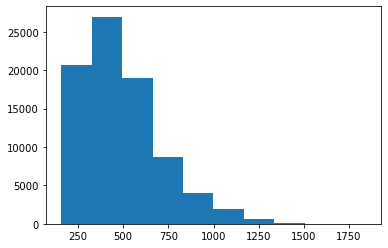

In [23]:
plt.hist(doc_lens.values)
print()

In [24]:
doc_lens.quantile(np.concatenate([np.arange(0, 0.15, 0.01), np.arange(0.90, 1.01, 0.01)]), interpolation="nearest")

0.00     157
0.01     184
0.02     194
0.03     201
0.04     208
0.05     215
0.06     222
0.07     228
0.08     234
0.09     239
0.10     244
0.11     250
0.12     256
0.13     262
0.14     267
0.90     793
0.91     813
0.92     837
0.93     860
0.94     887
0.95     924
0.96     970
0.97    1023
0.98    1084
0.99    1169
1.00    1842
dtype: int64

In [25]:
ds = Dataset(
    uuids=uuids,
    data=data,
    special_token_ids=special_token_ids,
    maxlen=128,
)
len(ds)

82161

In [26]:
data[uuids[0]]["span_data"][0]

{'span_num': 0,
 'discourse_id': '1617734767734.0',
 'is_real': True,
 'span_token_id': 128021,
 'start': 0,
 'end': 40,
 'num_real_tokens': 40,
 'start_special_token_id': 128003,
 'end_special_token_id': 128004,
 'discourse_type': 'Position',
 'token_type_start_id': 5,
 'token_type_in_id': 6,
 'token_type_end_id': 7,
 'target': array([0.01502458, 0.89244014, 0.09253527], dtype=float32)}

In [27]:
res = ds[2][0]
uuid, span_ids, input_ids, masks, target = res["uuids"], res["span_ids"], res["input_ids"], res["masks"], res["target"]

uuid[0], len(input_ids), len(masks), len(span_ids), len(target)

('0000D23A521A::psl::f2', 141, 141, 141, 141)

In [28]:
tokenizer.decode(input_ids)

'[CLS]<position><span::00> Some people belive that the so called "[MASK]<trunc...></position><evidence><span::01> It was not created by aliens, and[MASK][MASK]<trunc...></evidence><br><br><evidence><span::02>[MASK] mesa is a naturally<trunc...></evidence><claim><span::03> This "face" on[MASK][MASK] looks like a<trunc...></claim><br><br><counterclaim><span::04> Many conspiracy theorists believe that<trunc...></counterclaim><rebuttal><span::05> These people would be very wrong.<trunc...></rebuttal><evidence><span::06> NASA\'s budget would increase drasticly[MASK] which<trunc...></evidence><br><concluding-statement><span::07> So[MASK] NASA is not[MASK] life on Mars[MASK] us, and they are[MASK] trying to<trunc...></concluding-statement>[SEP]<essay><position><span::00></position><evidence><span::01></evidence><evidence><span::02></evidence><claim><span::03></claim><counterclaim><span::04></counterclaim><rebuttal><span::05></rebuttal><evidence><span::06></evidence><concluding-statement><span

In [29]:
def get_checkpoints(checkpoint_root):
  checkpoints = Path(checkpoint_root).glob("*.pth")
  chpts = {}
  for checkpoint in checkpoints:
    fold = re.search(r"_fold(\d+)_", checkpoint.stem).group(1)
    chpts[f"fold_{fold}"] = checkpoint
  return chpts

In [30]:
checkpoints_store = {
    "microsoft/deberta-large": "../data/fprize_microsoft_deberta-large_fold0_epoch_05_iov_v2_val_0.7418_20220625133915.pth",
    "microsoft/deberta-xlarge": "../data/fprize_microsoft_deberta-xlarge_fold0_epoch_05_iov_v2_val_0.7911_20220626043233.pth",
    "microsoft/deberta-v3-large": "../data/fprize_microsoft_deberta-v3-large_fold0_epoch_04_iov_v2_val_0.7346_20220625092726.pth",
    "microsoft/deberta-v2-xlarge": "../data/fprize_microsoft_deberta-v2-xlarge_fold0_epoch_05_iov_v2_val_0.7884_20220625194951.pth",
}

configs.checkpoints_store = checkpoints_store

In [ ]:
for epochs, folds in tqdm([(6, [i]) for i in range(5)]):

  configs.epochs = epochs

  ftype = "_" + configs.FORWARD_TYPE.split("_")[1]
  ftype = "" if ftype == "_base" else ftype
  mxp = "_mxp" if configs.USE_MIXUP else ""

  assert len(folds) == 1
  fold_uuids = uuid_with_folds_by_folds[folds[0]]
  fold_uuids = {uuid: f for uuid, f in fold_uuids.items() if uuid in data}

  train(
        uuids=fold_uuids,
        exclude_from_val=exclude_from_val_uuids,
        data=data,
        model_name=MODEL_NAME,
        val_maxlen=configs.VAL_MAXLEN,

        epochs=epochs-2,
        early_stop_epochs=epochs,

        folds=folds,
        save_each=configs.SAVE_EACH,
        suffix=f"_psl{ftype}_v3-1{mxp}-maxlen{configs.MAXLEN}",
        special_token_ids=special_token_ids,
        checkpoint_paths={f"fold_{i}": checkpoints_store[configs.MODEL_NAME] for i in range(5)},
        use_mixup=configs.USE_MIXUP,
        forward_type=configs.FORWARD_TYPE,
        model_config=config,
        other_model_params=configs.OTHER_MODEL_PARAMS,
  )


############################### [FOLD 0  SEED 321]


C:\Users\nerok\AppData\Roaming\Python\Python38\site-packages\transformers\convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
